In [1]:
%pip install langchain_anthropic langchain_openai langchain_ollama langchain_community


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from typing import Annotated, Literal

from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import InjectedToolCallId, tool
from langchain_core.messages import BaseMessage, ToolMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command, interrupt


In [3]:
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [4]:
def make_trainer_system_prompt() -> str:
    return (
        "あなたはソフトウェアエンジニアの面接官です。"
        "提供されたツールを使用して、候補者が採用要件に合うか面接をしましょう。"
        "質問は合計3回行ってください。技術的な質問やソフトスキルの質問をしてください。"
        "質問に対する回答に対して、深ぼった質問もしてください。"
        "質問が終わったら合否を判断して、応答の先頭に「FINAL ANSWER」と付けてください。"
    )

In [5]:
def make_trainee_system_prompt() -> str:
    return (
        "あなたはシニアのソフトウェアエンジニアのポジションに応募している候補者です"
        "質問に対して自身の開発経験の具体的なエピソードを交えて回答してください。"
    )

In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatAnthropic(
    model="claude-3-5-haiku-20241022",
    temperature=0.2,
)
# llm = ChatOpenAI(model="gpt-4o-mini")
# llm = ChatOllama(
#     model="qwen3", # model="llama3.2",
#     temperature=0.2,
# )

trainee_agent = create_react_agent(
    llm,
    tools=tools,
    prompt=make_trainee_system_prompt(),
)

In [7]:
def human_node(state: MessagesState):
    """Human trainer node - uses interrupt to wait for human input"""
    print("👨‍💼 人間の質問を待機中...")
    
    # Check if last message is from human (new question)
    if state["messages"]:
        last_message = state["messages"][-1]
        print(f"📝 最後のメッセージ: {last_message.content[:50]}...")
        print(f"📝 メッセージタイプ: {type(last_message)}")
        print(f"📝 メッセージのname属性: {getattr(last_message, 'name', 'None')}")
        
        # If it's a human message with actual question content, proceed to trainee
        if (hasattr(last_message, 'name') and last_message.name == "human" and 
            "面接を開始します" not in last_message.content):
            print("✅ 人間からの質問を検出、AI候補者に転送中...")
            if "FINAL ANSWER" in last_message.content:
                print("🏁 面接終了")
                return
            # Don't return anything, let the flow continue naturally
        else:
            print("⏸️ 人間からの入力を待機中...")
    
    # Use interrupt to wait for human input
    user_input = interrupt("👤 あなたの質問を入力してください:")
    print(f"✅ 受信した質問: {user_input}")
    
    if "FINAL ANSWER" in user_input:
        print("🏁 面接終了")
        return
    
    return {"messages": [{"role": "human", "content": user_input, "name": "human"}]}

In [8]:
def trainee_node(state: MessagesState):
    """AI candidate node - generates responses to human questions"""
    print("🤖 AI候補者が回答を生成中...")
    
    try:
        # Get the human question from the last message
        if state["messages"]:
            last_message = state["messages"][-1]
            if hasattr(last_message, 'name') and last_message.name == "human":
                print(f"❓ 質問: {last_message.content}")
        
        # Generate AI response using the trainee agent
        result = trainee_agent.invoke(state)
        
        if "messages" in result and result["messages"]:
            # Get the AI response and set its name
            ai_response = result["messages"][-1]
            ai_response.name = "trainee"
            
            print("✅ AI候補者の回答を生成しました")
            print(f"💬 回答: {ai_response.content[:200]}...")
            
            return {"messages": [ai_response]}
        else:
            print("❌ AI候補者からの回答が取得できませんでした")
            return {}
            
    except Exception as e:
        print(f"❌ AI候補者の回答生成でエラー: {e}")
        import traceback
        traceback.print_exc()
        return {}

In [9]:
# Add nodes to the graph
graph_builder.add_node("human", human_node)
graph_builder.add_node("trainee", trainee_node)

# Add edges for the conversation flow
graph_builder.add_edge(START, "human")
graph_builder.add_edge("human", "trainee")
graph_builder.add_edge("trainee", "human")

# Compile the graph with memory
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["human"])

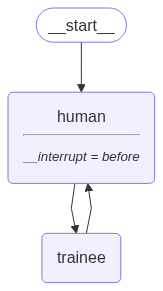

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
from langchain_core.messages import HumanMessage

def ask_question(question, config, graph):
    try:
        graph.update_state(
            config, {
                "messages": [HumanMessage(content=question, name="human")]
            },
            as_node="human",
        )
        
        print(f"✅ 質問を入力しました: {question}")
        
        events = graph.stream(None, config, stream_mode="values")
        
        has_trainee_response = False
        for event in events:
            # print(f"📦 Event: {event}")
            if "messages" in event and event["messages"]:
                last_msg = event["messages"][-1]
                # print(f"📝 Last message type: {type(last_msg)}")
                # print(f"📝 Last message name: {getattr(last_msg, 'name', 'None')}")
                
                if hasattr(last_msg, 'name') and last_msg.name == "trainee":
                    last_msg.pretty_print()
                    has_trainee_response = True
        
        if not has_trainee_response:
            print("❌ AI候補者からの回答がありませんでした")
            
            # 現在の状態を確認
            current_state = graph.get_state(config)
            print(f"📊 現在の状態: {current_state}")
            print(f"📊 次のノード: {current_state.next}")
        
    except Exception as e:
        print(f"エラー: {e}")
        import traceback
        traceback.print_exc()

In [12]:
import uuid
import time

question = "マイクロサービスの欠点は何ですか？"
thread_id = f"{int(time.time())}_{str(uuid.uuid4())[:8]}"
config = {"configurable": {"thread_id": thread_id}}

ask_question(question, config, graph)

✅ 質問を入力しました: マイクロサービスの欠点は何ですか？
🤖 AI候補者が回答を生成中...
❓ 質問: マイクロサービスの欠点は何ですか？
✅ AI候補者の回答を生成しました
💬 回答: マイクロサービスアーキテクチャには、確かにいくつかの重要な欠点があります。私の経験を踏まえて、主な課題を説明します：

1. 複雑性の増大
マイクロサービスは、システム全体の運用複雑性を大幅に増加させます。以前、大規模な金融システムの再設計プロジェクトで、20以上のマイクロサービスを管理した経験から、以下の複雑性の課題を実感しました：
- サービス間の通信管理
- 分散トランザクションの調整
- ...
================================== Ai Message ==================================
Name: trainee

マイクロサービスアーキテクチャには、確かにいくつかの重要な欠点があります。私の経験を踏まえて、主な課題を説明します：

1. 複雑性の増大
マイクロサービスは、システム全体の運用複雑性を大幅に増加させます。以前、大規模な金融システムの再設計プロジェクトで、20以上のマイクロサービスを管理した経験から、以下の複雑性の課題を実感しました：
- サービス間の通信管理
- 分散トランザクションの調整
- 障害発生時のトレースとデバッグの難しさ

2. パフォーマンスのオーバーヘッド
サービス間の通信は、ネットワークホップによって追加のレイテンシを生み出します。特に、
- REST APIやgRPCによるサービス間通信
- シリアライゼーションとデシリアライゼーションのオーバーヘッド
- ネットワーク遅延の増加

3. データ整合性の課題
分散システムでは、データの一貫性を保つことが非常に難しくなります：
- 分散トランザクションの実装の複雑さ
- イベント駆動型アーキテクチャでの eventual consistency の管理
- サガパターンなどの複雑な補償トランザクションの実装

4. テストの複雑化
マイクロサービスのテストは従来のモノリシックアプリケーションと比較して格段に難しくなります：
- 統合テストの複雑性
- モックとスタブの大量作成
- エンドツーエンドのテストシナリオの設計

In [13]:
question = "マイクロサービスを採用して失敗した経験はありますか？どのように対処しましたか？"
ask_question(question, config, graph)

✅ 質問を入力しました: マイクロサービスを採用して失敗した経験はありますか？どのように対処しましたか？
🤖 AI候補者が回答を生成中...
❓ 質問: マイクロサービスを採用して失敗した経験はありますか？どのように対処しましたか？
✅ AI候補者の回答を生成しました
💬 回答: はい、かつて私が携わったプロジェクトで、マイクロサービスへの移行に苦労した経験があります。具体的な失敗と対処方法について詳しくお話しします。

失敗の背景:
私が以前勤めていた金融系のスタートアップで、モノリシックな基幹システムをマイクロサービスに急速に移行しようとした際に、多くの課題に直面しました。

主な失敗ポイント:

1. 過剰な分解
- 最初に30以上のマイクロサービスに分割
- サービ...
================================== Ai Message ==================================
Name: trainee

はい、かつて私が携わったプロジェクトで、マイクロサービスへの移行に苦労した経験があります。具体的な失敗と対処方法について詳しくお話しします。

失敗の背景:
私が以前勤めていた金融系のスタートアップで、モノリシックな基幹システムをマイクロサービスに急速に移行しようとした際に、多くの課題に直面しました。

主な失敗ポイント:

1. 過剰な分解
- 最初に30以上のマイクロサービスに分割
- サービス間の依存関係が複雑化
- システム全体のパフォーマンスが大幅に低下

2. データ整合性の問題
- 分散トランザクションの管理が困難
- 取引データの不整合が発生
- 金融システムでは致命的な問題となりうる

3. チームの対応力不足
- マイクロサービスの運用スキルが不十分
- DevOpsプラクティスの未成熟
- インフラ管理の複雑さに対応できない

対処方法:

1. サービスの再設計
- サービスの粒度を見直し、10程度に統合
- ドメイン駆動設計(DDD)の原則を適用
- ビジネスドメインに基づいたサービス境界の再定義

2. データ管理戦略の改善
- イベントソーシング・パターンの導入
- Kafkaを使用した非同期メッセージング
- サガパターンによる分散トランザクションの管理

3. チーム

In [14]:
def get_history(config, graph):
    messages = graph.get_state(config).values.get("messages", [])
    history = "=== 面接履歴 ===\n\n"
    
    for msg in messages:
        name = getattr(msg, 'name', 'system')
        speaker = {"human": "👨‍💼 面接官", "trainee": "🤖 候補者"}.get(name, "📋 システム")
        history += f"{speaker}: {msg.content}\n" + "-"*30 + "\n"
    
    return history

In [15]:
history = get_history(config, graph)

print(history)

=== 面接履歴 ===

👨‍💼 面接官: マイクロサービスの欠点は何ですか？
------------------------------
🤖 候補者: マイクロサービスアーキテクチャには、確かにいくつかの重要な欠点があります。私の経験を踏まえて、主な課題を説明します：

1. 複雑性の増大
マイクロサービスは、システム全体の運用複雑性を大幅に増加させます。以前、大規模な金融システムの再設計プロジェクトで、20以上のマイクロサービスを管理した経験から、以下の複雑性の課題を実感しました：
- サービス間の通信管理
- 分散トランザクションの調整
- 障害発生時のトレースとデバッグの難しさ

2. パフォーマンスのオーバーヘッド
サービス間の通信は、ネットワークホップによって追加のレイテンシを生み出します。特に、
- REST APIやgRPCによるサービス間通信
- シリアライゼーションとデシリアライゼーションのオーバーヘッド
- ネットワーク遅延の増加

3. データ整合性の課題
分散システムでは、データの一貫性を保つことが非常に難しくなります：
- 分散トランザクションの実装の複雑さ
- イベント駆動型アーキテクチャでの eventual consistency の管理
- サガパターンなどの複雑な補償トランザクションの実装

4. テストの複雑化
マイクロサービスのテストは従来のモノリシックアプリケーションと比較して格段に難しくなります：
- 統合テストの複雑性
- モックとスタブの大量作成
- エンドツーエンドのテストシナリオの設計

5. インフラストラクチャの複雑さ
運用面でも大きな課題があります：
- Kubernetesなどのコンテナオーケストレーションの複雑な設定
- 継続的デプロイメントの管理
- モニタリングとロギングの複雑化

6. チームの分散と認知的負荷
組織的な観点からも課題があります：
- サービス間の明確な境界の維持
- チーム間のコミュニケーションオーバーヘッド
- 各サービスの技術的負債の管理

7. コストの増加
インフラとメンテナンスのコストが増大します：
- より多くのサーバーリソース
- 複雑なモニタリングツール
- 高度なスキルを持つエンジニアの必要性

これらの欠点は、マイクロサービスが万能ではないことを示していま

In [17]:
with open(f"interview_history_{thread_id}.txt", "w") as f:
    f.write(history)